# Download Dataset

In [1]:
# Constants
NUCLEUS_API_KEY = "test_5e1c456d97854e39915291f2b809a34a"
TRAIN_SLICE_ID = "slc_cack1pp6f5ag0ahn28d0"
TEST_SLICE_ID = "slc_cacmcf9x8n7g0qjrzdh0"

DATASET_PATH = "/home/gabriel_voxelai_com/data/unsupervised_door"

In [2]:
import nucleus
import requests
import os
from pathlib import Path
import gc
gc.collect()

10

In [3]:
def download_if_not_downloaded(slice_id):
    client = nucleus.NucleusClient(NUCLEUS_API_KEY)
    train_slice = client.get_slice(slice_id)

    raw_items = train_slice.export_raw_items()
    image_items = raw_items['raw_dataset_items']

    for item in image_items:
        metadata = item['metadata']
        response = requests.get(item['scale_url'])
        filepath = os.path.join(DATASET_PATH, metadata['split'], metadata['state'], item['ref_id'] + ".png")

        # Download if file does not exist
        if not os.path.exists(filepath):
            Path(filepath).parent.mkdir(exist_ok=True, parents=True)
            print(f"Downloading file: {filepath}")
            file = open(filepath, "wb+")
            file.write(response.content)
            file.close()
        else:
            print(f"File {filepath} exists")

In [4]:
# # Download train dataset
# download_if_not_downloaded(TRAIN_SLICE_ID)
# # Download test dataset
# download_if_not_downloaded(TEST_SLICE_ID)

# Feature Extraction

In [5]:
from PIL import Image
def get_largest_common_img_size(image_paths):
    width_min = np.inf
    height_min = np.inf
    for image_path in image_paths:
        image = Image.open(image_path)
        width, height = image.size[0:2]
        if width < width_min:
            width_min = width
        if height < height_min:
            height_min = height
    size = (width_min, height_min)
    return size

In [6]:
import numpy as np
import glob
import os
import torch
from torchvision import transforms
import matplotlib.pyplot as plt


DATASET_PATH = "/home/gabriel_voxelai_com/data/unsupervised_door"
image_paths = glob.glob(DATASET_PATH + '/**/*.png', recursive=True)
image_paths.extend(glob.glob(DATASET_PATH + '/**/*.jpg', recursive=True))

DOOR_CLASSES = np.array(['open', 'partially_open', 'closed'])
STANDARD_IMG_SIZE = (32, 32)
HIGHEST_COMMON_SIZE = get_largest_common_img_size(image_paths)
N_CHANNELS = 3

In [7]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        image_tensor: torch.Tensor,
        image_labels: torch.Tensor,
        channel_means: np.array,
        channel_std: np.array,
    ):
        self.data = image_tensor
        self.labels = image_labels
        self.channel_mean = channel_means
        self.channel_std = channel_std
        self.image_width = image_tensor.shape[2]
        self.image_height = image_tensor.shape[3]


    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.labels[idx]

        return self.normalize(data), label


    def __len__(self):
        return self.data.shape[0]


    def normalize(self, image_tensor: torch.Tensor) -> torch.Tensor:
        normalize_transform = transforms.Normalize(
            mean=self.channel_mean,
            std=self.channel_std,
        )
        return normalize_transform(image_tensor)


    def undo_normalization(self, normalized_image_tensor: torch.Tensor) -> torch.Tensor:
        unnormalize_transform = transforms.Compose([
            transforms.Normalize(mean = [0, 0, 0], std = 1 / self.channel_std),
            transforms.Normalize(mean = -self.channel_mean, std = [1, 1, 1]),
        ])
        return unnormalize_transform(normalized_image_tensor)

In [8]:
def get_image_label(
    image_path: str,
    door_classes: np.array = np.array(['open', 'partially_open', 'closed'])
) -> np.array:
    image_class = image_path.split(os.path.sep)[-2]
    label = (np.where(door_classes == image_class)[0][0])
    return label

In [9]:
def get_data_and_labels(image_paths: list, n_channels: int, image_size: tuple) -> tuple:
    data = torch.zeros(len(image_paths), n_channels, image_size[0], image_size[1])
    labels = torch.zeros(len(image_paths))
    tensor_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
    ])
    for i, image_path in enumerate(image_paths):
        pil_image = Image.open(image_path)
        data[i] = tensor_transform(pil_image)
        labels[i] = get_image_label(image_path)
    
    return data, labels

In [10]:
def get_channel_mean_and_std(image_tensor_data):
    channel_means = image_tensor_data.mean(dim=(0, 2, 3))
    channel_stds = image_tensor_data.std(dim=(0, 2, 3))
    return channel_means, channel_stds

In [11]:
# GET DATA
train_images = [path for path in image_paths if 'train' in path]
test_images = [path for path in image_paths if 'test' in path]
ood_images = [path for path in image_paths if 'ood' in path]

IMG_SIZE_TO_USE = STANDARD_IMG_SIZE
train_data, train_labels = get_data_and_labels(train_images, N_CHANNELS, IMG_SIZE_TO_USE)
train_channel_mean, train_channel_std = get_channel_mean_and_std(train_data)
test_data, test_labels = get_data_and_labels(test_images, N_CHANNELS, IMG_SIZE_TO_USE)
test_channel_mean, test_channel_std = get_channel_mean_and_std(test_data)
ood_data, ood_labels = get_data_and_labels(ood_images, N_CHANNELS, IMG_SIZE_TO_USE)
ood_channel_mean, ood_channel_std = get_channel_mean_and_std(ood_data)

In [12]:
# Get Dataloader
train_door_dataset = ImageDataset(
    train_data,
    train_labels,
    train_channel_mean,
    train_channel_std,
)
train_door_dataloader = torch.utils.data.DataLoader(
    train_door_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=1,
    pin_memory=False
)
test_door_dataset = ImageDataset(
    test_data,
    test_labels,
    train_channel_mean,
    train_channel_std,
)
test_door_dataloader = torch.utils.data.DataLoader(
    test_door_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=1,
    pin_memory=False
)
ood_door_dataset = ImageDataset(
    ood_data,
    ood_labels,
    train_channel_mean,
    train_channel_std,
)

# VAE

In [13]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import TQDMProgressBar
from pl_bolts.models.autoencoders import VAE
import torch
from torch import nn
from torchvision import datasets
from torchvision import transforms
import random
from PIL import Image

In [14]:
def get_latent_space(vae_model, normalized_data_tensor) -> torch.Tensor:
    resnet_encoding = vae_model.encoder(normalized_data_tensor)
    mu = vae_model.fc_mu(resnet_encoding)
    var = vae_model.fc_var(resnet_encoding)
    _, _, latent_space = vae_model.sample(mu, var)
    return latent_space

In [15]:
torch.cuda.empty_cache()
pl.seed_everything(42)

vae = VAE(input_height=train_door_dataset.image_height)
trainer = pl.Trainer(gpus=1, max_epochs=30, callbacks=[TQDMProgressBar(refresh_rate=10)])
trainer.fit(vae, train_door_dataloader)

INFO:pytorch_lightning.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/home/gabriel_voxelai_com/.cache/bazel/_bazel_gabriel_voxelai_com/bed6170ec9381771b0cff4fbbaf5980e/execroot/voxel/bazel-out/k8-fastbuild/bin/third_party/jupyter/jupyter.runfiles/pip_deps_pytorch_lightning/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type          | Param

/home/gabriel_voxelai_com/.cache/bazel/_bazel_gabriel_voxelai_com/bed6170ec9381771b0cff4fbbaf5980e/execroot/voxel/bazel-out/k8-fastbuild/bin/third_party/jupyter/jupyter.runfiles/pip_deps_torch/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


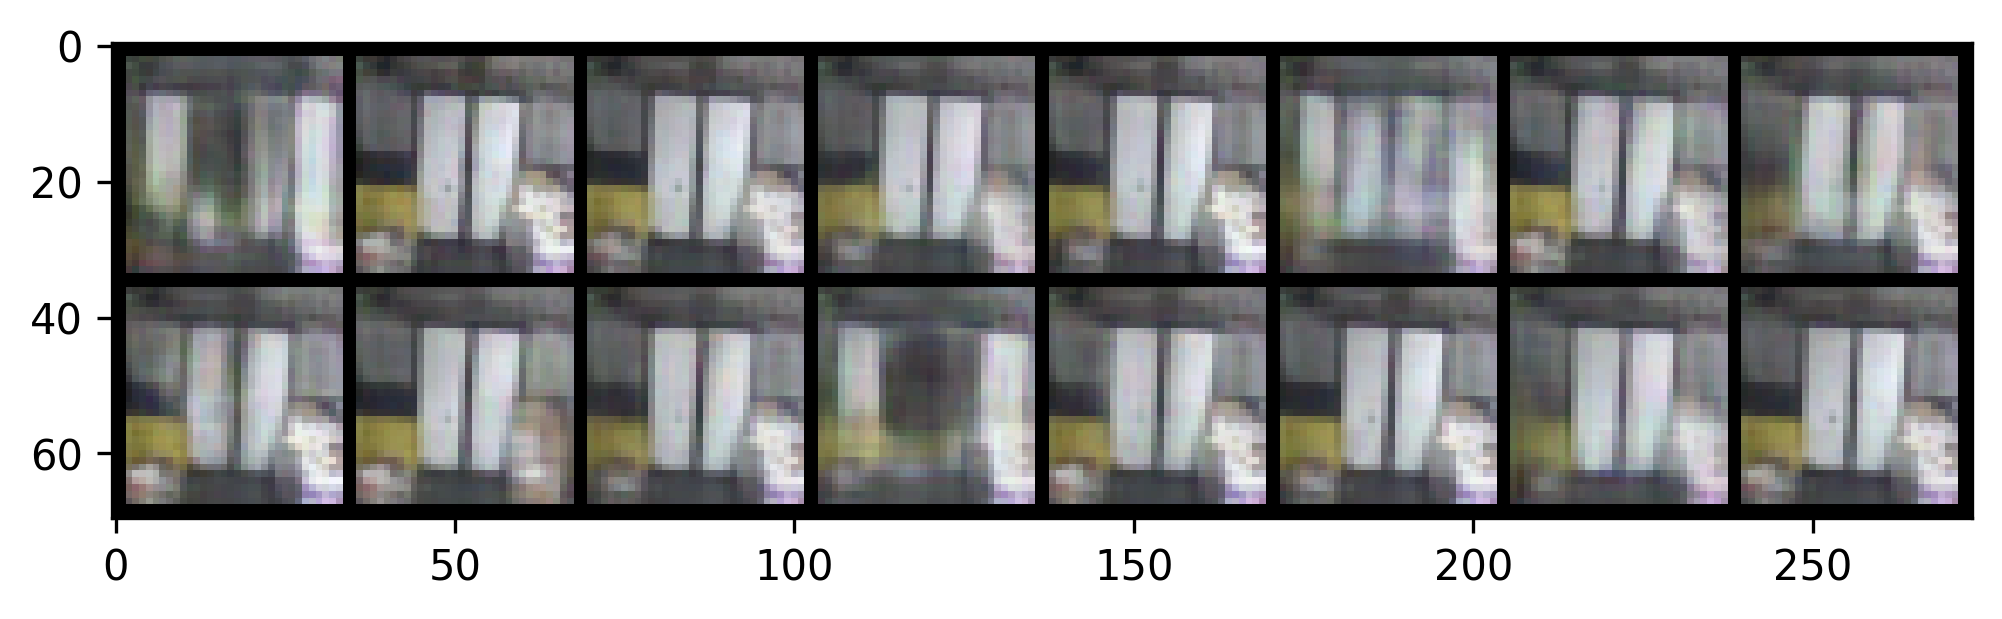

In [16]:
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
NUM_PREDS = 16

plt.figure(figsize=(8, 3), dpi=300)
# Z COMES FROM NORMAL(0, 1)
p = torch.distributions.Normal(torch.zeros(1, vae.fc_mu.out_features), torch.zeros((1, vae.fc_var.out_features))+1)
z = p.rsample((NUM_PREDS,))

# SAMPLE IMAGES
with torch.no_grad():
    pred = vae.decoder(z.to(vae.device)).cpu()


pred = train_door_dataset.undo_normalization(pred)

img = make_grid(pred).permute(1, 2, 0).numpy()
plt.imshow(img)
plt.show()

In [18]:
# Create Encodings
train_class = train_labels.numpy()
test_class = test_labels.numpy()
ood_class = ood_labels.numpy()
with torch.no_grad():
    train_data_normalized = train_door_dataset.normalize(train_data)
    train_latent = get_latent_space(vae, train_data_normalized).numpy()

# KNN on Encodings

In [19]:
NUM_NEIGHBORS = 5
NUM_JOBS = -1
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import time

In [20]:
# train and evaluate a k-NN classifer on the raw pixel intensities
knn = KNeighborsClassifier(n_neighbors=NUM_NEIGHBORS, n_jobs=NUM_JOBS)
knn.fit(train_latent, train_class)
with torch.no_grad():
    start_time = time.time()
    test_data_normalized = train_door_dataset.normalize(test_data)
    test_latent = get_latent_space(vae, test_data_normalized).numpy()
    acc_test = knn.score(test_latent, test_class)
    test_eval_time = time.time() - start_time
    start_time = time.time()
    ood_data_normalized = train_door_dataset.normalize(ood_data)
    ood_latent = get_latent_space(vae, ood_data_normalized).numpy()
    acc_ood = knn.score(ood_latent, ood_class)
    ood_eval_time = time.time() - start_time
    print(f"Test Inference, N: {test_data.shape[0]}, Time: {test_eval_time}s, TPI: {test_eval_time / test_data.shape[0]}s, Accuracy: {acc_test*100:.2f}")
    print(f"OOD Inference, N: {ood_data.shape[0]}, Time: {ood_eval_time}, TPI: {ood_eval_time / ood_data.shape[0]}, Accuracy: {acc_ood*100:.2f}")

Test Inference, N: 834, Time: 3.6048903465270996s, TPI: 0.004322410487442565s, Accuracy: 95.68
OOD Inference, N: 78, Time: 0.4310770034790039, TPI: 0.005526628249730819, Accuracy: 74.36


Classes: ['open' 'partially_open' 'closed']
Raw: Per Class Precision [0.93684211 0.88888889 0.96377953]
Raw: Per Class Recall [0.99441341 0.18604651 1.        ]


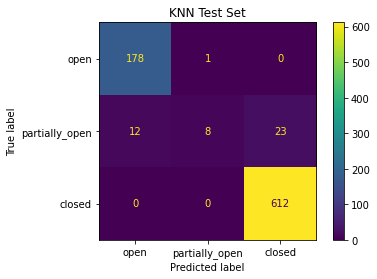

In [21]:
y_pred = knn.predict(test_latent)
print(f"Classes: {DOOR_CLASSES}")
print(f"Raw: Per Class Precision {precision_score(test_class, y_pred, average=None)}")
print(f"Raw: Per Class Recall {recall_score(test_class, y_pred, average=None)}")
cm = confusion_matrix(test_class, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=DOOR_CLASSES)
disp.plot()
plt.title('KNN Test Set')
plt.show()

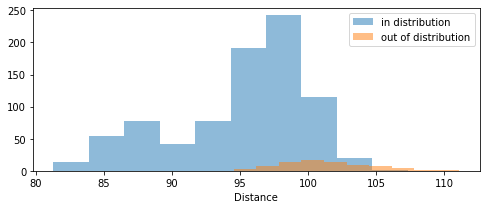

In [22]:
test_knn_dist, _ = knn.kneighbors(test_latent, n_neighbors=NUM_NEIGHBORS, return_distance=True)
ood_knn_dist, _ = knn.kneighbors(ood_latent, n_neighbors=NUM_NEIGHBORS, return_distance=True)

test_knn_dist = test_knn_dist.sum(axis=1)
ood_knn_dist = ood_knn_dist.sum(axis=1)

plt.figure(figsize=(8, 3))
plt.hist(test_knn_dist, alpha=0.5, label='in distribution')
plt.hist(ood_knn_dist, alpha=0.5, label='out of distribution')
plt.legend(loc='upper right')
plt.xlabel("Distance")
plt.show()

# SVM

In [23]:
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

In [24]:
C = 1.0 # regularization
kernel = 'poly'
degree = 3
clf = SVC(C=C, kernel=kernel, degree=degree)
clf.fit(train_latent, train_class)
with torch.no_grad():
    start_time = time.time()
    test_data_normalized = train_door_dataset.normalize(test_data)
    test_latent = get_latent_space(vae, test_data_normalized).numpy()
    acc_test = clf.score(test_latent, test_class)
    test_eval_time = time.time() - start_time
    start_time = time.time()
    ood_data_normalized = train_door_dataset.normalize(ood_data)
    ood_latent = get_latent_space(vae, ood_data_normalized).numpy()
    acc_ood = clf.score(ood_latent, ood_class)
    ood_eval_time = time.time() - start_time
    print(f"Test Inference, N: {test_data.shape[0]}, Time: {test_eval_time}s, TPI: {test_eval_time / test_data.shape[0]}s, Accuracy: {acc_test*100:.2f}")
    print(f"OOD Inference, N: {ood_data.shape[0]}, Time: {ood_eval_time}, TPI: {ood_eval_time / ood_data.shape[0]}, Accuracy: {acc_ood*100:.2f}")

Test Inference, N: 834, Time: 3.4993340969085693s, TPI: 0.004195844240897566s, Accuracy: 93.41
OOD Inference, N: 78, Time: 0.2566254138946533, TPI: 0.0032900694089058116, Accuracy: 100.00


Classes: ['open' 'partially_open' 'closed']
Raw: Per Class Precision [0.93714286 0.16666667 0.95475819]
Raw: Per Class Recall [0.91620112 0.06976744 1.        ]


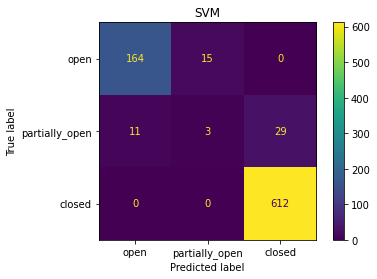

In [25]:
y_pred = clf.predict(test_latent)
print(f"Classes: {DOOR_CLASSES}")
print(f"Raw: Per Class Precision {precision_score(test_class, y_pred, average=None)}")
print(f"Raw: Per Class Recall {recall_score(test_class, y_pred, average=None)}")
cm = confusion_matrix(test_class, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=DOOR_CLASSES)
disp.plot()
plt.title('SVM')
plt.show()

# LOGISTIC REGRESSION

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
logistic_regr = LogisticRegression(solver='lbfgs', max_iter=1000)
logistic_regr.fit(train_latent, train_class)
with torch.no_grad():
    start_time = time.time()
    test_data_normalized = train_door_dataset.normalize(test_data)
    test_latent = get_latent_space(vae, test_data_normalized).numpy()
    acc_test = logistic_regr.score(test_latent, test_class)
    test_eval_time = time.time() - start_time
    start_time = time.time()
    ood_data_normalized = train_door_dataset.normalize(ood_data)
    ood_latent = get_latent_space(vae, ood_data_normalized).numpy()
    acc_ood = logistic_regr.score(ood_latent, ood_class)
    ood_eval_time = time.time() - start_time
    print(f"Test Inference, N: {test_data.shape[0]}, Time: {test_eval_time}s, TPI: {test_eval_time / test_data.shape[0]}s, Accuracy: {acc_test*100:.2f}")
    print(f"OOD Inference, N: {ood_data.shape[0]}, Time: {ood_eval_time}, TPI: {ood_eval_time / ood_data.shape[0]}, Accuracy: {acc_ood*100:.2f}")

Test Inference, N: 834, Time: 3.4769344329833984s, TPI: 0.004168986130675538s, Accuracy: 92.45
OOD Inference, N: 78, Time: 0.37493205070495605, TPI: 0.004806821162884052, Accuracy: 71.79


Classes: ['open' 'partially_open' 'closed']
Raw: Per Class Precision [0.92146597 0.16666667 0.96247961]
Raw: Per Class Recall [0.98324022 0.11627907 0.96405229]


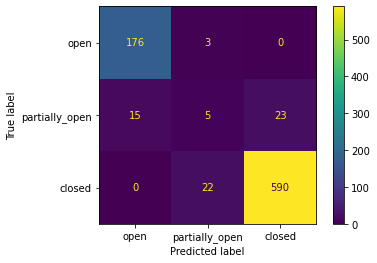

In [27]:
y_pred = logistic_regr.predict(test_latent)
print(f"Classes: {DOOR_CLASSES}")
print(f"Raw: Per Class Precision {precision_score(test_class, y_pred, average=None)}")
print(f"Raw: Per Class Recall {recall_score(test_class, y_pred, average=None)}")
cm = confusion_matrix(test_class, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=DOOR_CLASSES)
disp.plot()
plt.show()